# Introduction

This notebook includes experiments on auxiliary learning. Please see the corresponding [repository](https://github.com/vivien000/auxiliary-learning)  and the associated blog post.

In [0]:
!apt install imagemagick &>/dev/null

In [0]:
import tensorflow as tf
import tensorflow.contrib.eager as tfe
import numpy as np

from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.layouts import gridplot
from bokeh.resources import CDN
from bokeh.embed import file_html

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import seaborn as sns

tf.enable_eager_execution()

In [0]:
def censored_vector(u, v, mode='Projection'):
  """Adjusts the auxiliary loss gradient
  
  Adjusts the auxiliary loss gradient before adding it to the primary loss
  gradient and using a gradient descent-based method
  
  Args:
    u: A tensorflow variable representing the auxiliary loss gradient
    v: A tensorflow variable representing the primary loss gradient
    mode: The method used for the adjustment:
      - Single task: the auxiliary loss gradient is ignored
      - Multitask: the auxiliary loss gradient is kept as it is
      - Unweighted cosine: cf. https://arxiv.org/abs/1812.02224
      - Weighted cosine: cf. https://arxiv.org/abs/1812.02224
      - Projection: cf. https://github.com/vivien000/auxiliary-learning
      - Parameter-wise: same as projection but at the level of each parameter
    
  Returns:
    A tensorflow variable representing the adjusted auxiliary loss gradient
  """
  if mode == 'Single task':
    return 0  
  if mode == 'Multitask':
    return u
  l_u, l_v = tf.norm(u), tf.norm(v)
  if l_u.numpy() == 0 or l_v.numpy() == 0:
    return u
  u_dot_v = tf.reduce_sum(u*v)
  if mode == 'Unweighted cosine':
    return u if u_dot_v > 0 else tf.zeros_like(u)
  if mode == 'Weighted cosine':
    return tf.maximum(u_dot_v, 0)*u/l_u/l_v
  if mode == 'Projection':
    return u - tf.minimum(u_dot_v, 0)*v/l_v/l_v
  if mode == 'Parameter-wise':
    return u*((tf.math.sign(u*v)+1)/2)


def train(primary_function,
          auxiliary_function,
          optimizer,
          mode='Projection',
          start=[0, 0],
          lam=0.1,
          iterations=5000,
          stopping_criterion=None,
          patience=10):
  x = tf.Variable(np.array(start), dtype=tf.float32)
  xs = np.expand_dims(x.numpy(), 0)

  crierion_met = 0
  for i in range(iterations):
    
    with tf.GradientTape(persistent=True) as tape:
      primary_loss = primary_function(x)
      auxiliary_loss = auxiliary_function(x)
    
    primary_grad = tape.gradient(primary_loss, x)
    auxiliary_grad = tape.gradient(auxiliary_loss, x)
    new_grad = censored_vector(auxiliary_grad,
                               primary_grad,
                               mode=mode)
    optimizer.apply_gradients([(primary_grad + lam*new_grad, x)])
    
    xs = np.concatenate([xs, np.expand_dims(x.numpy(), 0)])
    
    if stopping_criterion is not None:
      if stopping_criterion(x):
        criterion_met += 1
        if stop_iteration is None:
          stop_iteration = i
        if criterion_met == patience:
          return xs, stop_iteration
      else:
        criterion_met, stop_iteration = 0, None
  
  return xs

In [0]:
def draw_charts(trajectories, modes, colors, c):
  
  output_notebook()

  s1 = figure(match_aspect=True, plot_width=400, plot_height=400)
  s1.circle(0, 0, radius=1, fill_color='grey', fill_alpha=.2, line_color='grey')
  s1.circle(1, 0, radius=1, fill_color='grey', fill_alpha=.2, line_color='grey')
  for i in range(len(trajectories)):
    xs = trajectories[i]
    s1.line(xs[:, 0],
            xs[:, 1],
            line_width=2,
            color=colors[i],
            legend=modes[i])
  s1.title.text = 'Trajectories'
  s1.yaxis.axis_label = 'y'
  s1.xaxis.axis_label = 'x'
  s1.legend.location = 'top_right'
  s1.legend.click_policy='hide'

  s2 = figure(plot_width=400, plot_height=400)
  for i in range(len(trajectories)):
    xs = trajectories[i]
    s2.line(range(xs.shape[0]),
            np.sqrt(xs[:, 0]**2+xs[:, 1]**2),
            line_width=2,
            color=colors[i],
            legend=modes[i])
  s2.legend.location = 'top_right'
  s2.legend.click_policy = 'hide'
  s2.title.text = 'Distance to the origin by optimization step'
  s2.yaxis.axis_label = 'Distance to the origin'
  s2.xaxis.axis_label = 'Steps'

  s3 = figure(plot_width=400, plot_height=400)
  for i in range(len(trajectories)):
    xs = trajectories[i]
    s3.line(range(xs.shape[0]),
            np.sqrt(np.sum((xs-c)**2, axis=1)),
            line_width=2,
            color=colors[i],
            legend=modes[i])
  s3.legend.location = 'top_right'
  s3.legend.click_policy = 'hide'
  s3.title.text = 'Distance to (%d, %d) by optimization step' % (c[0], c[1])
  s3.yaxis.axis_label = 'Distance to (%d, %d)' % (c[0], c[1])
  s3.xaxis.axis_label = 'Steps'

  p = gridplot([[s1, s2, s3]])
  show(p)
  return file_html(p, CDN, "my plot")

In [0]:
modes = ['Multitask',
         'Projection',
         'Unweighted cosine',
         'Weighted cosine']

# Toy experiment presented in the blog post

## Bokeh figures

In [0]:
%%time
c = tf.constant(np.array([2, 0]), dtype=tf.float32)
primary_function = lambda x: (tf.sqrt(tf.reduce_sum(x**2))-1)**2
auxiliary_function = lambda x: tf.reduce_sum((x-c)**2)
stopping_criterion = lambda x: np.sum((x.numpy()-np.array([1, 0]))**2) < 1e-4

trajectories_adam = [train(primary_function,
                           auxiliary_function,
                           tf.train.AdamOptimizer(0.01),
                           mode=mode,
                           start=[0, 2])
                     for mode in modes]

colors = ['black', 'red', 'orange', 'blue', 'green']
html = draw_charts(trajectories_adam, modes, colors, c.numpy())

Loading BokehJS ...

CPU times: user 4min 32s, sys: 27 s, total: 4min 59s
Wall time: 5min 27s


In [0]:
%%time
trajectories_vanilla_gd = [train(primary_function,
                                 auxiliary_function,
                                 tf.train.GradientDescentOptimizer(0.01),
                                 mode=mode,
                                 start=[0, 2])
                           for mode in modes]

draw_charts(trajectories_vanilla_gd, modes, colors, c.numpy())

Loading BokehJS ...

CPU times: user 3min 50s, sys: 23 s, total: 4min 13s
Wall time: 4min 43s


## Gif versions of the figures

In [0]:
def sign_dot_product(x):
  primary_grad_direction = np.array(x) * (1 if (x[0]**2+x[1]**2 < 1) else -1)
  auxiliary_grad_direction = np.array([2, 0]) - np.array(x)
  return 1 if primary_grad_direction.dot(auxiliary_grad_direction) > 0 else -1

def animation(trajectories, steps, filename, edge=False):
  sns.set_style("white")
  sns.set_style("ticks")
  fig = plt.figure()
  ax = fig.gca()
  ax.set_adjustable("box")
  sns.despine()
  plt.gca().set_aspect('equal')
  plt.ylim((0, 2))
  plt.xlim(-1, 2)
  x_ticks, y_ticks = np.arange(-1, 2.5, .5), np.arange(0, 2.5, .5)
  x_labels = ['-1', '-0.5', '0', '0.5', '1', '1.5', '2']
  y_labels = ['0', '0.5', '1', '1.5', '2']
  ax.xaxis.set_major_locator(matplotlib.ticker.FixedLocator(x_ticks))
  ax.yaxis.set_major_locator(matplotlib.ticker.FixedLocator(y_ticks))
  ax.xaxis.set_major_formatter(matplotlib.ticker.FixedFormatter(x_labels))
  ax.yaxis.set_major_formatter(matplotlib.ticker.FixedFormatter(y_labels))

  circle1 = plt.Circle((0, 0), 1, color='grey', alpha=0.2, zorder=0)
  circle2 = plt.Circle((1, 0), 1, color='grey', alpha=0.2, zorder=0)
  ax.add_artist(circle1)
  ax.add_artist(circle2)

  palette = sns.color_palette("tab10", n_colors=10)
  palette = [palette[0], palette[2], palette[3], palette[4]]

  lines, points = [], []
  for mode in range(4):
    lines.append(ax.plot(trajectories[mode][:1, 0],
                         trajectories[mode][:1, 1],
                         color=palette[mode],
                         label=modes[mode])[0])
    points.append(ax.plot(trajectories[mode][:1, 0][-1],
                          trajectories[mode][:1, 1][-1],
                          color=palette[mode],
                          marker='o',
                          markeredgewidth=1.0)[0])

  plt.legend()
  plt.tight_layout()

  def update(i):
    for mode in range(4):
      lines[mode].set_xdata(trajectories[mode][:i, 0])
      lines[mode].set_ydata(trajectories[mode][:i, 1])
      
      x = trajectories[mode][:i, :][-1, :]
      points[mode].set_xdata(x[0])
      points[mode].set_ydata(x[1])
      if edge:
        if sign_dot_product(x) == -1:
          points[mode].set_markeredgecolor('black')
        else:
          points[mode].set_markeredgecolor(palette[mode])
    return lines+points

  anim = FuncAnimation(fig,
                       update,
                       frames=np.arange(1, steps, 100),
                       interval=100)
  anim.save(filename, dpi=80, writer='imagemagick')

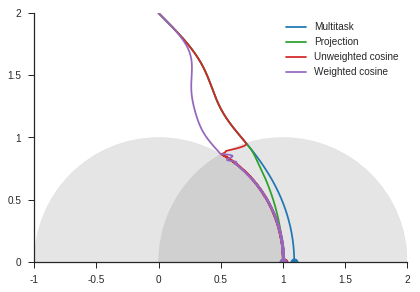

In [0]:
matplotlib.rcParams['figure.figsize'] = 6, 4.5
animation(trajectories_adam, 5000, 'trajectories_adam.gif')

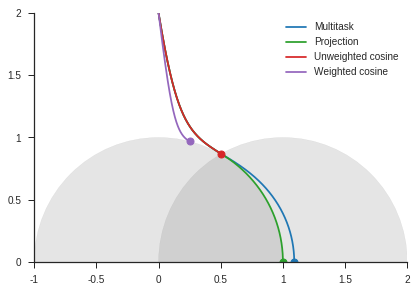

In [0]:
animation(trajectories_vanilla_gd, 2000, 'trajectories_vanilla_gd.gif')

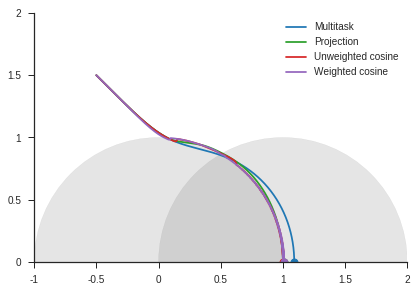

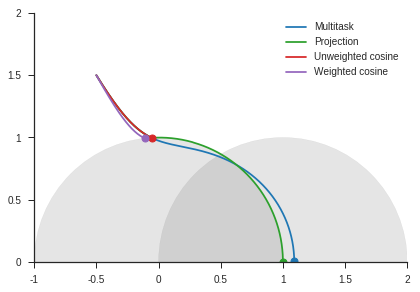

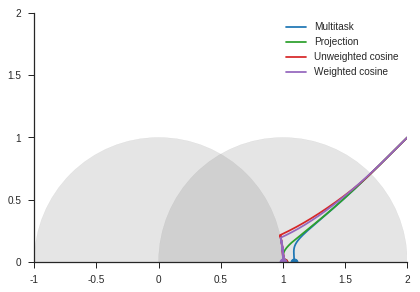

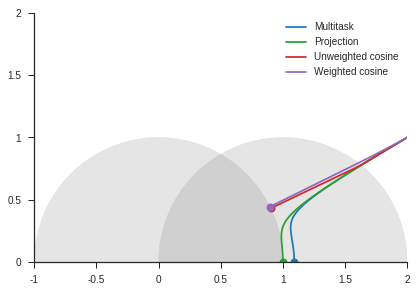

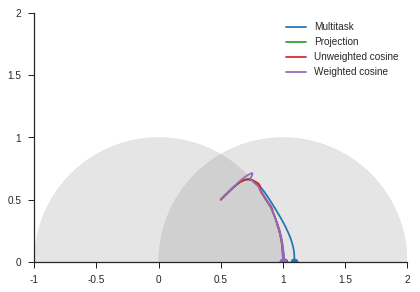

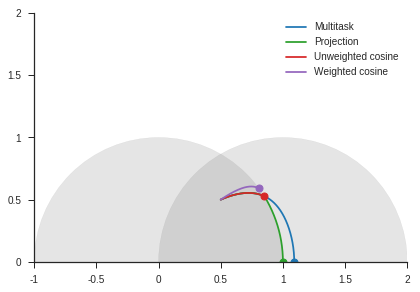

In [0]:
c = tf.constant(np.array([2, 0]), dtype=tf.float32)
primary_function = lambda x: (tf.sqrt(tf.reduce_sum(x**2))-1)**2
auxiliary_function = lambda x: tf.reduce_sum((x-c)**2)

starting_points = [[-0.5, 1.5], [2, 1], [0.5, 0.5]]

for i in range(3):
  trajectories_adam = [train(primary_function,
                             auxiliary_function,
                             tf.train.AdamOptimizer(0.01),
                             mode=mode,
                             start=starting_points[i])
                       for mode in modes]
  animation(trajectories_adam, 5000, 'trajectories_adam%d.gif' %(i+2))
  trajectories_vanilla = [train(primary_function,
                                auxiliary_function,
                                tf.train.GradientDescentOptimizer(0.01),
                                mode=mode,
                                start=starting_points[i])
                          for mode in modes]
  animation(trajectories_vanilla, 2000, 'trajectories_vanilla_gd%d.gif' %(i+2))


# Experiments similar to those presented on Figure 1 of [Adapting Auxiliary Losses Using Gradient Similarity](https://arxiv.org/abs/1812.02224)

In [0]:
%%time
c = tf.constant(np.array([1, 1]), dtype=tf.float32)
primary_function = lambda x: tf.reduce_sum(x**2)
auxiliary_function = lambda x: tf.reduce_sum((x-c)**2)
stopping_criterion = lambda x: primary_function(x) < 0.1
lambdas = [0.1, 1, 1, 1, 1]
starting_points = [[-2, 1.5], [-0.5, 2], [-1.5, -1.5], [0.5, 0.8], [1, 0.5]]

runs = [[train(primary_function,
               auxiliary_function,
               tf.train.GradientDescentOptimizer(0.01),
               mode=modes[i],
               lam=lambdas[i],
               start=start,
               stopping_criterion=stopping_criterion,
               iterations=600)
         for start in starting_points]
         for i in range(4)]

CPU times: user 14.5 s, sys: 1.69 s, total: 16.1 s
Wall time: 11.7 s


In [0]:
output_notebook()
colors = ['yellow', 'red', 'blue', 'orange', 'green']

grid = []

for j in range(len(runs)):
  trajectories = runs[j]
  s1 = figure(plot_width=400, plot_height=400, x_range=(-2, 2), y_range=(-2, 2))
  s1.circle(0,
            0,
            radius=np.sqrt(.1),
            fill_color='lightgrey',
            line_color='lightgrey')
  for i in range(len(trajectories)):
    xs = trajectories[i][0]
    s1.line(xs[:, 0],
            xs[:, 1],
            line_width=2,
            color=colors[i])
  s1.title.text = modes[j]
  s1.yaxis.axis_label = 'y'
  s1.xaxis.axis_label = 'x'

  s2 = figure(plot_width=400, plot_height=400, x_range=(0, 600))
  for i in range(len(trajectories)):
    xs = trajectories[i][0]
    n = trajectories[i][1]
    legend = 'Conv time: %s' % ('Inf' if n is None else str(n))
    s2.line(range(xs.shape[0]),
            np.sqrt(np.sum(xs**2, axis=1)),
            line_width=2,
            color=colors[i],
            legend=legend)
  s2.legend.location = 'top_right'
  s2.legend.click_policy='hide'
  s2.yaxis.axis_label = 'Distance to the origin'
  s2.xaxis.axis_label = 'Steps'

  grid.append([s1, s2])

p = gridplot(grid)
show(p)


Loading BokehJS ...